In [15]:

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline


In [9]:

def create_pre_trained_model(local_weights_file):

  pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False, 
                                  weights = None) 

  pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for layer in pre_trained_model.layers:
    layer.trainable = False

  return pre_trained_model


In [3]:
os.getcwd()

'/Users/chidam_sp/PycharmProjects/pythonProject2/Computer vision, Time series, and NLP_TF certification/cats_vs_dogs'

In [10]:

local_weights_file = '/Users/chidam_sp/PycharmProjects/pythonProject2/Computer vision, Time series, and NLP_TF certification/horses_vs_humans/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()


2024-04-30 12:08:13.617417: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-04-30 12:08:13.617472: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-30 12:08:13.617483: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-30 12:08:13.617900: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-30 12:08:13.618233: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

In [19]:

def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    train_datagen = ImageDataGenerator(rescale=1./255, 
                                       rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode='nearest')

    
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR, 
                                                        batch_size=128, class_mode='binary', target_size=(150, 150))
    # save_to_dir=/tmp/img-data-gen-outputs
    
    validation_datagen = ImageDataGenerator(rescale=1./255)
    
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR, 
                                                                  batch_size=32, class_mode='binary', target_size=(150, 150))
    
    return train_generator, validation_generator


class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.93):
            print("\nReached 93% accuracy so cancelling training!")
            self.model.stop_training = True
            

def output_of_last_layer(pre_trained_model):
    last_desired_layer = pre_trained_model.get_layer('mixed9')
    print('last layer output shape: ', last_desired_layer.output_shape)
    last_output = last_desired_layer.output
    print('last layer output: ', last_output)
    return last_output

def create_final_model(pre_trained_model, last_output):
    from tensorflow.keras import Model
    x = layers.Flatten()(last_output)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.2)(x)  
    x = layers.Dense(1, activation='sigmoid')(x)     
    model = Model(inputs=pre_trained_model.input, outputs=x)
    model.compile(optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0001), 
                    loss = 'binary_crossentropy',
                metrics = ['accuracy']) 
    return model
            
            
def model_training(EPOCHS, pre_trained_model, model_checkpoint_path):
    import datetime
    
    start_time = datetime.datetime.now()
    train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

    callbacks = myCallback()
    last_output = output_of_last_layer(pre_trained_model)
    model = create_final_model(pre_trained_model, last_output)
    
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_checkpoint_path, monitor='loss', mode='min', save_best_only=True)
    
    history = model.fit(train_generator, epochs=EPOCHS, validation_data=validation_generator, verbose=2, callbacks=[callbacks, model_checkpoint])
    end_time = datetime.datetime.now()
    print("Training time: ", end_time - start_time)
    return history       


In [18]:
del pre_trained_model, history

In [20]:

TRAINING_DIR = '/Users/chidam_sp/PycharmProjects/pythonProject2/Computer vision, Time series, and NLP_TF certification/cats_vs_dogs/train_valid_split/training/'

VALIDATION_DIR = '/Users/chidam_sp/PycharmProjects/pythonProject2/Computer vision, Time series, and NLP_TF certification/cats_vs_dogs/train_valid_split/testing/'

model_checkpoint_path = '/Users/chidam_sp/PycharmProjects/pythonProject2/Computer vision, Time series, and NLP_TF certification/cats_vs_dogs/model_through_transfer_learning.h5'

pre_trained_model = create_pre_trained_model(local_weights_file)
history = model_training(10, pre_trained_model, model_checkpoint_path)


Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
last layer output shape:  (None, 3, 3, 2048)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 3, 3, 2048), dtype=tf.float32, name=None), name='mixed9/concat:0', description="created by layer 'mixed9'")
Epoch 1/10


/Users/chidam_sp/codify_odi/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


176/176 - 79s - loss: 0.2215 - accuracy: 0.9212 - val_loss: 0.0855 - val_accuracy: 0.9740 - 79s/epoch - 450ms/step
Epoch 2/10

Reached 93% accuracy so cancelling training!
176/176 - 96s - loss: 0.1535 - accuracy: 0.9424 - val_loss: 0.0775 - val_accuracy: 0.9728 - 96s/epoch - 545ms/step
Training time:  0:02:56.025600


In [21]:

def plot_learning_curve_metric(history, lower_limit, upper_limit):
    plt.plot(history['accuracy'], label='training_accuracy')
    plt.plot(history['val_accuracy'], label='validation_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.ylim([lower_limit, upper_limit])
    plt.legend(loc='lower right')

def plot_learning_curve_loss(history, lower_limit, upper_limit):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.ylim([lower_limit, upper_limit])
    plt.legend(loc='upper right')
    plt.show()


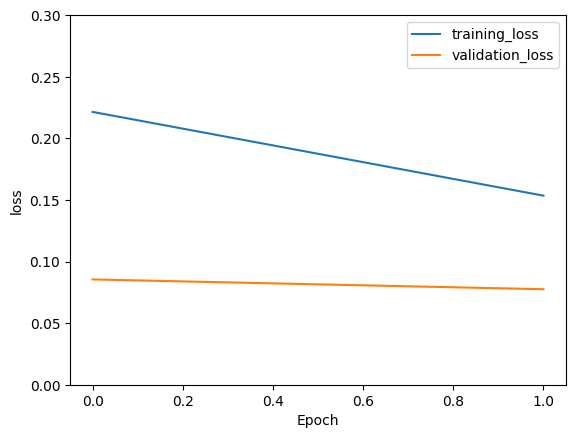

In [23]:

plot_learning_curve_loss(history.history, 0, 0.3)


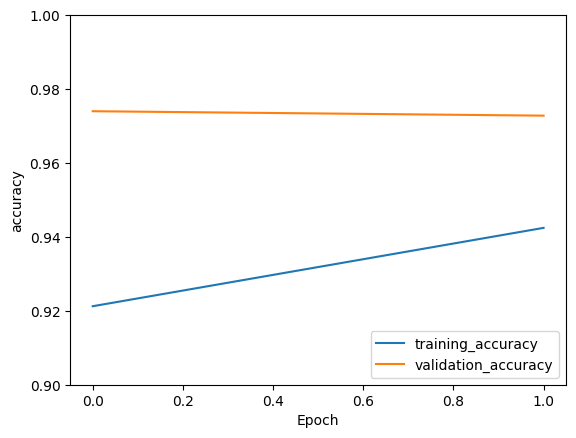

In [26]:

plot_learning_curve_metric(history.history, 0.9, 1)


In [27]:

del pre_trained_model, history


In [28]:

from tensorflow.keras.backend import clear_session
clear_session()
